# Forecasting Series Tiempo

**Objetivo:**:  Mejorar la toma de decisiones, optimizar recursos y brindar una experiencia superior a los clientes.

**Necesidad:** Anticipar las ventas de los próximos 30 días para evitar problemas de inventario.

**Problema a resolver:** ¿Cómo anticipar las ventas futuras para tomar decisiones acertadas sobre inventarios y recursos, reduciendo el impacto de los períodos de alta y baja demanda?

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [4]:
DATA_PATH = os.path.join('..', '..', 'data', 'input', 'forecasting')

In [5]:
data = pd.read_csv(os.path.join(DATA_PATH, 'data_processed.csv'))

In [6]:
data

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Year,Month
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315,2010,2
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315,2010,2
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315,2010,2
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315,2010,2
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315,2010,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
420280,45,98,2012-09-28,508.37,False,64.88,3.997,192.013558,8.684,B,118221,2012,9
420281,45,98,2012-10-05,628.10,False,64.89,3.985,192.170412,8.667,B,118221,2012,10
420282,45,98,2012-10-12,1061.02,False,54.47,4.000,192.327265,8.667,B,118221,2012,10
420283,45,98,2012-10-19,760.01,False,56.47,3.969,192.330854,8.667,B,118221,2012,10


In [7]:
data = data.groupby('Date')['Weekly_Sales'].sum().reset_index()
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [8]:
data

,Weekly_Sales
Date,
2010-02-05,49750875.98
2010-02-12,48336800.10
2010-02-19,48277902.33
2010-02-26,43970440.65
2010-03-05,46872715.16
...,...
2012-09-28,43735713.56
2012-10-05,47567053.49
2012-10-12,46128909.98


## Modelado

### SARIMA

Comencemos utilizando el modelo SARIMA, es una extensión del modelo ARIMA que permite capturar patrones estacionales en series temporales.

Utilizaremos los siguientes parámetros:

1. Parámetros del orden no estacional (p, d, q)
- p = 1 (AR): El componente autoregresivo considera el valor previo de la serie temporal para hacer predicciones. Esto indica que la relación entre el valor actual y el anterior tiene influencia significativa.
- d = 1 (I): Se diferencia la serie una vez para hacerla estacionaria, lo cual se evidenció necesario dado el resultado de la prueba de Dickey-Fuller.
- q = 1 (MA): Se incluye un componente de media móvil de orden 1 para modelar la dependencia entre el valor actual y el error aleatorio previo.

2. Parámetros del orden estacional (P, D, Q, s)
- P = 1 (AR estacional): El valor actual de la serie está relacionado con el mismo período de tiempo en temporadas anteriores.
- D = 1 (diferenciación estacional): Se realiza una diferenciación estacional para eliminar tendencias estacionales persistentes.
- Q = 1 (MA estacional): Se modela el componente de media móvil estacional.
- s = 52 (periodicidad): La periodicidad de 52 semanas se selecciona porque los datos tienen una frecuencia semanal y se observó una estacionalidad anual.

In [537]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar SARIMA
model = SARIMAX(data['Weekly_Sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
result = model.fit()
print(result.summary())


d:\PREGRADO INGENIERÍA DE SISTEMAS E INFORMÁTICA\2024-2. Redes Neuronales\trabajo_3\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
d:\PREGRADO INGENIERÍA DE SISTEMAS E INFORMÁTICA\2024-2. Redes Neuronales\trabajo_3\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
d:\PREGRADO INGENIERÍA DE SISTEMAS E INFORMÁTICA\2024-2. Redes Neuronales\trabajo_3\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -1432.623
Date:                            Sat, 15 Feb 2025   AIC                           2875.247
Time:                                    21:47:53   BIC                           2887.746
Sample:                                02-05-2010   HQIC                          2880.287
                                     - 10-26-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1576      0.637      0.247      0.805      -1.091       1.406
ma.L1         -0.3065      0.629   

In [538]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Separación en train-test
train = data.iloc[:-30]
test = data.iloc[-30:]

# Evaluación de SARIMA
forecast_sarima = result.get_forecast(steps=30).predicted_mean
rmse = root_mean_squared_error(test, forecast_sarima)
mae = mean_absolute_error(test, forecast_sarima)
mape = mean_absolute_percentage_error(test, forecast_sarima)
print(f"RMSE: {rmse}, MAE: {mae}, MAPE: {mape}")


RMSE: 7270179.163007494, MAE: 5086717.687207287, MAPE: 0.10897167698729011


Coeficientes:
- ar.L1 (0.1576): Componente autorregresivo (AR) de primer orden. Indica una relación positiva moderada con la observación anterior.
- ma.L1 (-0.3065): Componente de media móvil (MA). Fuerte corrección negativa de los errores pasados.
- ar.S.L52 (-0.6353): Componente autorregresivo estacional (AR) con periodicidad de 52 semanas. El coeficiente negativo indica una influencia moderada y decreciente de los ciclos estacionales.
- sigma2 (4.006e+12): Varianza del error del modelo. Un valor alto puede indicar alta variabilidad en los datos.

Métricas Evaluativas
- RMSE: 7270179
- MAE: 5086717
- MAPE: 10.89%

El error promedio absoluto (MAE) y el porcentaje de error (MAPE) son relativamente bajos, lo que indica que SARIMA logró capturar decentemente la dinámica de las ventas.

El término de varianza (sigma2) extremadamente alto y la magnitud del error sugieren que el modelo podría mejorar su ajuste a la serie. La tendencia creciente y estacionalidad compleja pueden haber sido difíciles de modelar para SARIMA.

### Modelo de RNN y LSTM

Lo primero es normalizar los datos y convertir la serie en secuencias que la red pueda procesar.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [10]:
data = pd.read_csv(os.path.join(DATA_PATH, 'data_processed.csv'))

In [11]:
# Agrupar las ventas semanales
temp_data = data.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Fusionar con el resto de las variables
data = temp_data.merge(data[['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Size']]
					.groupby('Date').mean(), on='Date')

# Crear nuevas características
data['Date'] = pd.to_datetime(data['Date'])
data['weekday'] = data['Date'].dt.weekday
data['month'] = data['Date'].dt.month
data.set_index('Date', inplace=True)
data.fillna(0, inplace=True)

# Separar la variable objetivo antes de escalar
target = data[['Weekly_Sales']]
features = data.drop(columns=['Weekly_Sales'])

In [12]:
# Escalar características y variable objetivo por separado
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target)

# Recombinar los datos para la generación de secuencias
data_scaled = np.hstack((target_scaled, features_scaled))

In [13]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), :])  # Todas las variables
        y.append(data[i + sequence_length, 0])  # Solo la variable objetivo
    return np.array(X), np.array(y)

sequence_length = 30
X, y = create_sequences(data_scaled, sequence_length)

# División en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


Ahora, usemos una arquitectura sencilla para comenzar.

In [1066]:
# Definir el modelo LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compilación del modelo
model.compile(optimizer='adam', loss='mse')


d:\PREGRADO INGENIERÍA DE SISTEMAS E INFORMÁTICA\2024-2. Redes Neuronales\trabajo_3\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [1072]:
# Entrenar el modelo, manteniendo los mejores pesos
checkpoint = ModelCheckpoint('../../models/forecasting/model1.keras', save_best_only=True)
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/200


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0116 - val_loss: 0.0014
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0126 - val_loss: 0.0016
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0094 - val_loss: 0.0044
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0113 - val_loss: 0.0035
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0091 - val_loss: 0.0015
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0124 - val_loss: 0.0016
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0114 - val_loss: 0.0028
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0085 - val_loss: 0.0033
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0121 - val_loss: 0.0022
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0106 - val_loss: 0.0022
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0149 - val_loss: 0.0019
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0129 - val_loss: 0.0040
E

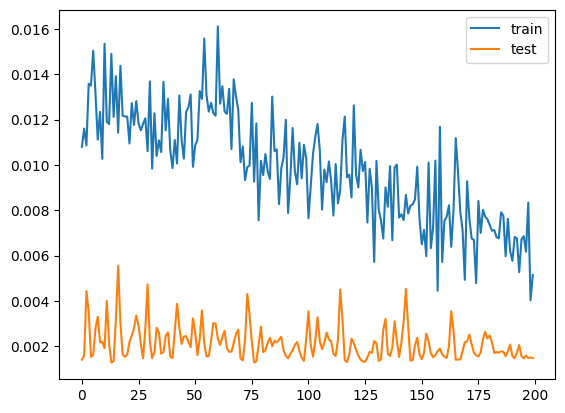

In [1073]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [1074]:
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [1075]:
# Evaluación del modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"RMSE: {rmse}, MAE: {mae}, MAPE: {mape}")

RMSE: 0.038607846283736334, MAE: 0.0278507458878924, MAPE: 0.16730951132981844


In [1]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Valores Reales')
plt.plot(y_pred, label='Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.legend()
plt.show()


NameError: name 'plt' is not defined

In [2]:
def predict_future(model, last_sequence, steps_ahead):
    future_predictions = []
    input_seq = last_sequence.copy()

    for _ in range(steps_ahead):
        # Hacer una predicción
        pred = model.predict(input_seq.reshape(1, sequence_length, -1))[0, 0]

        # Guardar la predicción
        future_predictions.append(pred)

        # Agregar la predicción a la secuencia eliminando el primer elemento
        next_input = np.hstack(([pred], input_seq[-1, 1:]))  # Mantiene las demás características
        input_seq = np.vstack((input_seq[1:], next_input))

    # Transformar los valores predichos a la escala original
    return scaler_target.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

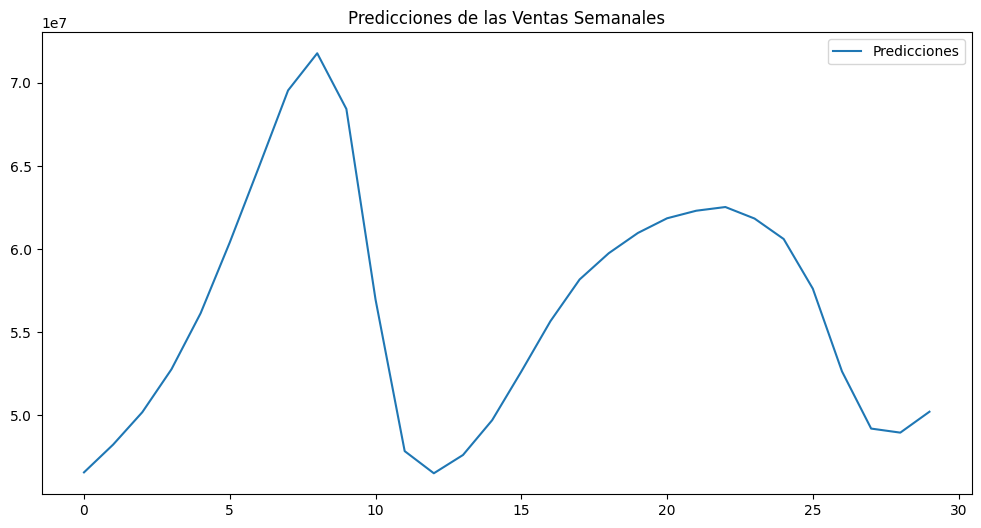

In [1081]:
# Tomar los últimos 30 días disponibles
last_sequence = X_test[-1]

# Predecir los próximos 30 días
predicted_sales = predict_future(model, last_sequence, 30)

# Graficar las predicciones de los próximos 30 días
plt.figure(figsize=(12, 6))
plt.plot(predicted_sales, label='Predicciones')
plt.title('Predicciones de las Ventas Semanales')
plt.legend()
plt.show()

### Segundo modelo usando RNN y LSTM

In [1031]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [1032]:
data = pd.read_csv(os.path.join(DATA_PATH, 'data_processed.csv'))

In [ ]:
# Agrupar las ventas semanales
temp_data = data.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Fusionar con el resto de las variables
data = temp_data.merge(data[['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Size']]
					.groupby('Date').mean(), on='Date')

# Crear nuevas características
data['Date'] = pd.to_datetime(data['Date'])
data['weekday'] = data['Date'].dt.weekday
data['month'] = data['Date'].dt.month
data.set_index('Date', inplace=True)
data.fillna(0, inplace=True)

# Separar la variable objetivo antes de escalar
target = data[['Weekly_Sales']]
features = data.drop(columns=['Weekly_Sales'])

In [ ]:
# Escalar características y variable objetivo por separado
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target)

# Recombinar los datos para la generación de secuencias
data_scaled = np.hstack((target_scaled, features_scaled))

In [ ]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), :])  # Todas las variables
        y.append(data[i + sequence_length, 0])  # Solo la variable objetivo
    return np.array(X), np.array(y)

sequence_length = 30
X, y = create_sequences(data_scaled, sequence_length)

# División en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [1082]:
# Modelo LSTM
model2 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

model2.compile(optimizer='adam', loss='mse')


d:\PREGRADO INGENIERÍA DE SISTEMAS E INFORMÁTICA\2024-2. Redes Neuronales\trabajo_3\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [1091]:
checkpoint = ModelCheckpoint('../../models/forecasting/model2.keras', save_best_only=True)

history2 = model2.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint],
    verbose=1
)


Epoch 1/200


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0051 - val_loss: 0.0041
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0079 - val_loss: 0.0040
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0083 - val_loss: 0.0056
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0083 - val_loss: 0.0051
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0069 - val_loss: 0.0033
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0062 - val_loss: 0.0029
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0091 - val_loss: 0.0045
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0074 - val_loss: 0.0066
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0079 - val_loss: 0.0055
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0057 - val_loss: 0.0038
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0064 - val_loss: 0.0032
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0057 - val_loss: 0.0033
E

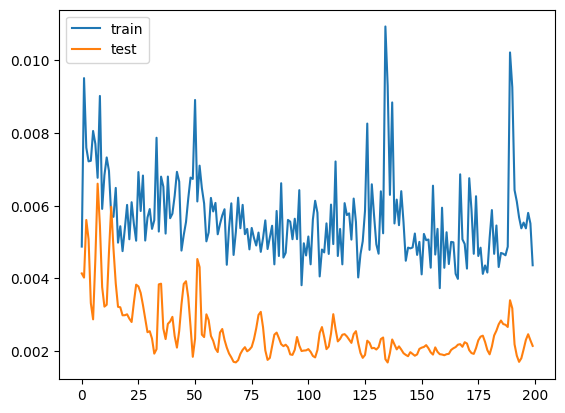

In [1092]:
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

In [1093]:
# Predicciones
y_pred2 = model2.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [1094]:
# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred2))
mae = mean_absolute_error(y_test, y_pred2)
mape = mean_absolute_percentage_error(y_test, y_pred2)
print(f"RMSE: {rmse}, MAE: {mae}, MAPE: {mape}")

RMSE: 0.04629780570266652, MAE: 0.03993662387795832, MAPE: 0.25113556058698244


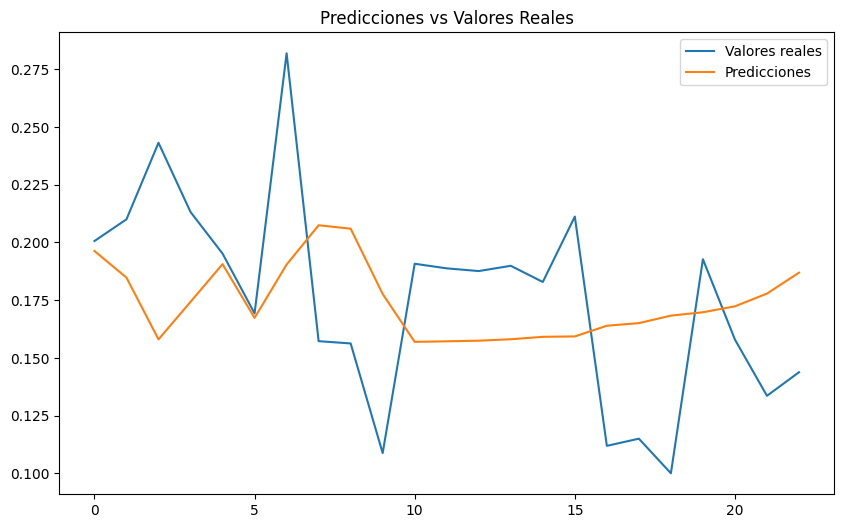

In [1095]:
# Gráfico de predicciones vs reales
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores reales')
plt.plot(y_pred2, label='Predicciones')
plt.legend()
plt.title("Predicciones vs Valores Reales")
plt.show()

In [1096]:
def predict_future(model, last_sequence, steps_ahead):
    future_predictions = []
    input_seq = last_sequence.copy()

    for _ in range(steps_ahead):
        # Hacer una predicción
        pred = model.predict(input_seq.reshape(1, sequence_length, -1))[0, 0]

        # Guardar la predicción
        future_predictions.append(pred)

        # Agregar la predicción a la secuencia eliminando el primer elemento
        next_input = np.hstack(([pred], input_seq[-1, 1:]))  # Mantiene las demás características
        input_seq = np.vstack((input_seq[1:], next_input))

    # Transformar los valores predichos a la escala original
    return scaler_target.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

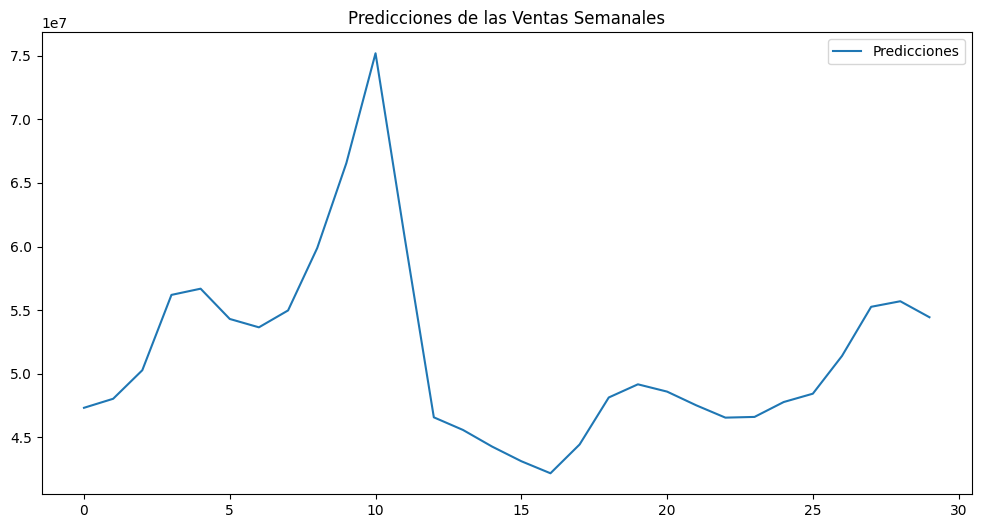

In [1097]:
# Tomar los últimos 30 días disponibles
last_sequence = X_test[-1]

# Predecir los próximos 30 días
predicted_sales2 = predict_future(model2, last_sequence, 30)

# Graficar las predicciones de los próximos 30 días
plt.figure(figsize=(12, 6))
plt.plot(predicted_sales2, label='Predicciones')
plt.title('Predicciones de las Ventas Semanales')
plt.legend()
plt.show()

### Tercer modelo usando RNN LSTM y GRU

In [1042]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [1043]:
data = pd.read_csv(os.path.join(DATA_PATH, 'data_processed.csv'))

In [ ]:
# Agrupar las ventas semanales
temp_data = data.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Fusionar con el resto de las variables
data = temp_data.merge(data[['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Size']]
					.groupby('Date').mean(), on='Date')

# Crear nuevas características
data['Date'] = pd.to_datetime(data['Date'])
data['weekday'] = data['Date'].dt.weekday
data['month'] = data['Date'].dt.month
data.set_index('Date', inplace=True)
data.fillna(0, inplace=True)

# Separar la variable objetivo antes de escalar
target = data[['Weekly_Sales']]
features = data.drop(columns=['Weekly_Sales'])

In [ ]:
# Escalar características y variable objetivo por separado
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target)

# Recombinar los datos para la generación de secuencias
data_scaled = np.hstack((target_scaled, features_scaled))

In [1121]:
features

,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Size,weekday,month
Date,,,,,,,,
2010-02-05,33.284630,2.717941,167.357048,8.578049,0.0,137427.979986,4,2
2010-02-12,33.370444,2.695955,167.401961,8.567855,1.0,137675.080027,4,2
2010-02-19,37.039727,2.673587,167.372455,8.574993,0.0,137274.186469,4,2
2010-02-26,38.636031,2.685449,167.724288,8.562098,0.0,137355.873598,4,2
2010-03-05,42.367490,2.731923,167.680036,8.573890,0.0,137556.273161,4,3
...,...,...,...,...,...,...,...,...
2012-09-28,68.163750,3.858017,175.983576,7.222354,0.0,136080.131775,4,9
2012-10-05,65.449390,3.848439,175.992008,6.940704,0.0,136484.789350,4,10
2012-10-12,57.678090,3.896989,176.161362,6.949037,0.0,136284.739846,4,10


In [1122]:
features_scaled

array([[0.06654125, 0.0335029 , 0.03215666, ..., 0.85765094, 0.        ,
        0.09090909],
       [0.06818923, 0.01689578, 0.03701387, ..., 1.        , 0.        ,
        0.09090909],
       [0.13865453, 0.        , 0.03382285, ..., 0.76905378, 0.        ,
        0.09090909],
       ...,
       [0.53499581, 0.92410686, 0.98432153, ..., 0.19905469, 0.        ,
        0.81818182],
       [0.58243092, 0.90997051, 1.        , ..., 0.        , 0.        ,
        0.81818182],
       [0.58984937, 0.84388084, 0.99203317, ..., 0.10581735, 0.        ,
        0.81818182]])

In [1120]:
data_scaled[0]

array([0.24558922, 0.06654125, 0.0335029 , 0.03215666, 0.99939043,
       0.        , 0.85765094, 0.        , 0.09090909])

In [ ]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), :])  # Todas las variables
        y.append(data[i + sequence_length, 0])  # Solo la variable objetivo
    return np.array(X), np.array(y)

sequence_length = 30
X, y = create_sequences(data_scaled, sequence_length)

# División en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [1098]:
model3 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    GRU(64, return_sequences=True),
    Dropout(0.1),
    LSTM(32, return_sequences=False),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dense(1)
])

model3.compile(optimizer='adam', loss='mse')

d:\PREGRADO INGENIERÍA DE SISTEMAS E INFORMÁTICA\2024-2. Redes Neuronales\trabajo_3\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [1106]:
checkpoint = ModelCheckpoint('../../models/forecasting/model3.keras', save_best_only=True)
history3 = model3.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/200


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0063 - val_loss: 0.0020
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0073 - val_loss: 0.0016
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0065 - val_loss: 0.0018
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0063 - val_loss: 0.0015
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0076 - val_loss: 0.0014
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0056 - val_loss: 0.0014
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0053 - val_loss: 0.0013
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0043 - val_loss: 0.0015
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0044 - val_loss: 0.0014
E

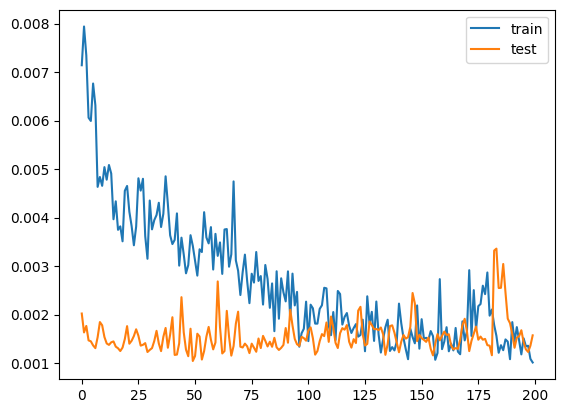

In [1107]:
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='test')
plt.legend()
plt.show()

In [1108]:
# Predicciones
y_pred3 = model3.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [1109]:
# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred3))
mae = mean_absolute_error(y_test, y_pred3)
mape = mean_absolute_percentage_error(y_test, y_pred3)
print(f"RMSE: {rmse}, MAE: {mae}, MAPE: {mape}")

RMSE: 0.039658258587783, MAE: 0.0300151422593211, MAPE: 0.17020586787095743


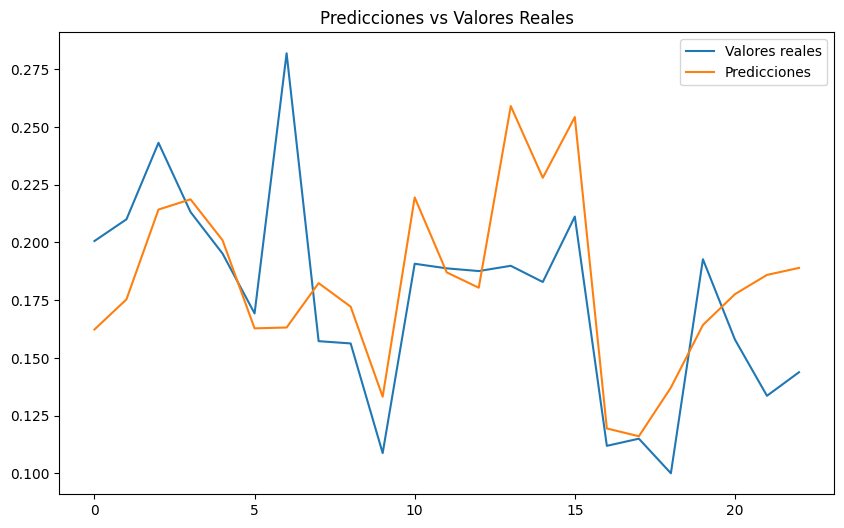

In [1111]:
# Gráfico de predicciones vs reales
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores reales')
plt.plot(y_pred3, label='Predicciones')
plt.legend()
plt.title("Predicciones vs Valores Reales")
plt.show()

In [1112]:
def predict_future(model, last_sequence, steps_ahead):
    future_predictions = []
    input_seq = last_sequence.copy()

    for _ in range(steps_ahead):
        # Hacer una predicción
        pred = model.predict(input_seq.reshape(1, sequence_length, -1))[0, 0]

        # Guardar la predicción
        future_predictions.append(pred)

        # Agregar la predicción a la secuencia eliminando el primer elemento
        next_input = np.hstack(([pred], input_seq[-1, 1:]))  # Mantiene las demás características
        input_seq = np.vstack((input_seq[1:], next_input))

    # Transformar los valores predichos a la escala original
    return scaler_target.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

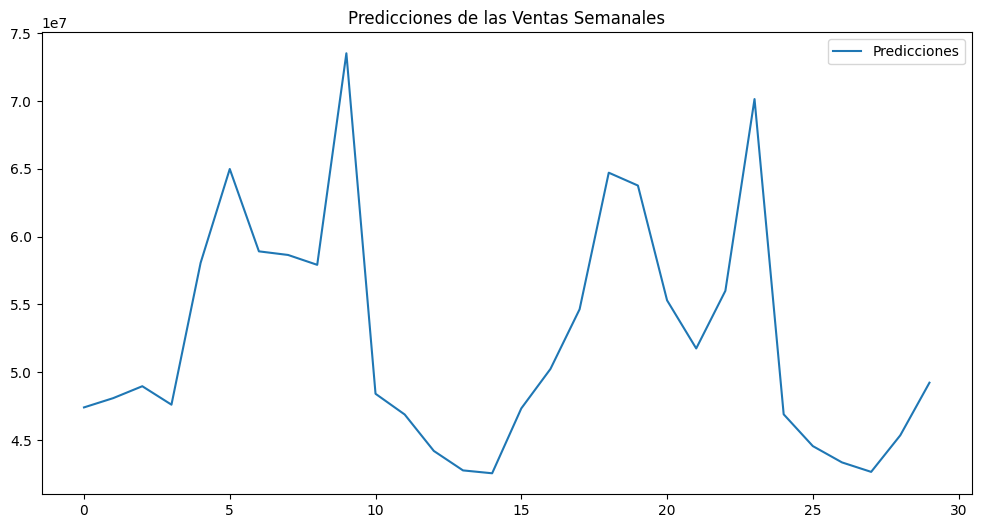

In [1113]:
# Tomar los últimos 30 días disponibles
last_sequence = X_test[-1]

# Predecir los próximos 30 días
predicted_sales3 = predict_future(model3, last_sequence, 30)

# Graficar las predicciones de los próximos 30 días
plt.figure(figsize=(12, 6))
plt.plot(predicted_sales3, label='Predicciones')
plt.title('Predicciones de las Ventas Semanales')
plt.legend()
plt.show()

## Evaluación

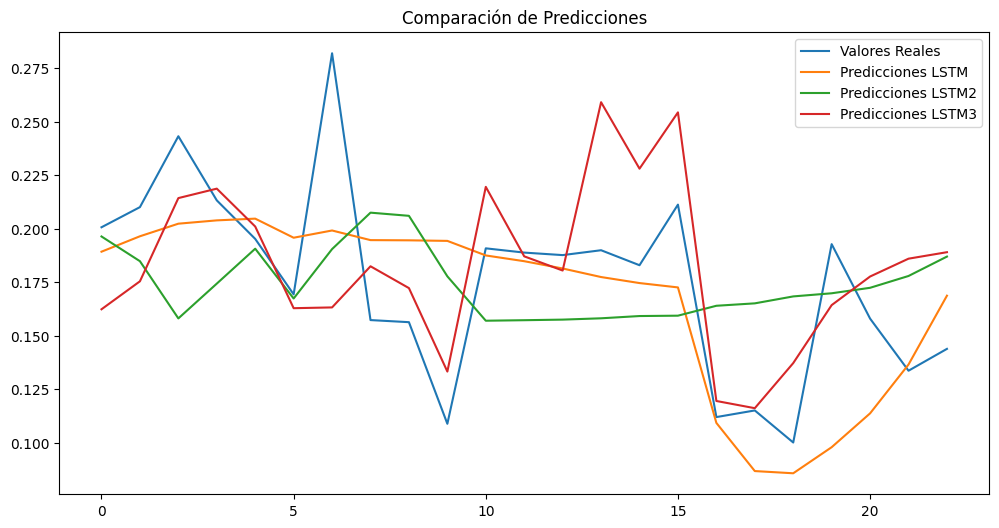

In [1110]:
# Comparación de las predicciones de los tres modelos
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Valores Reales')
plt.plot(y_pred, label='Predicciones LSTM')
plt.plot(y_pred2, label='Predicciones LSTM2')
plt.plot(y_pred3, label='Predicciones LSTM3')
plt.title('Comparación de Predicciones')
plt.legend()
plt.show()